我们首先梳理几个术语的区别：`Graph Embedding`, `Graph Neural Network`, `Graph Convolutional Network`。

Graph Embedding: 属于表示学习的范畴，通常有两个层次的含义：
1. 将图中节点表示成低维、实值、稠密的向量形式，用于节点分类等等
2. 将整个图表示成低维、实值、稠密的向量形式，用来对整个图结构进行分类

图嵌入的方式有以下三种：
1. 矩阵分解： 将节点间的关系用矩阵形式表达，分解矩阵得到嵌入向量，常用的矩阵有邻接矩阵、拉普拉斯矩阵、节点转移概率矩阵和节点属性矩阵等。
2. DeepWalk： 将节点看做单词，随机游走的节点序列看做句子，然后将其作为word2vec的输入，得到节点的嵌入表示
3. Graph Neural Network： 图神经网络可以应用于图嵌入来得到图或者节点的向量表示。

类比CNN的卷积操作，图神经网络的卷积操作是什么样呢，我们接下来就来看看图神经网络下特征的提取过程。

我们先定义一个图，对于图$G = (V, E)$, $V$是节点的集合，$E$是边的集合，对于图中每一个节点$i(i=1,\dots,N)$,均有对应的特征向量$x_i$。整张图的特征用矩阵$X_{N*D}$,其中$N$表示图中的节点数，$D$表示每个节点的特征数，即特征向量的维度。

图还有几个比较重要的矩阵：
1. 邻接矩阵：Adjacency matrix
2. 度矩阵：Degree matrix
3. Laplacian matrix： $L = D - A$

下面我们举一个无向图的例子，看一下各个量具体是什么

In [6]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
#图的特征表示
X = torch.tensor([
    [1, 3, 5],
    [1, 4, 9],
    [3, 4, 9],
    [3, 5, 7],
    [5, 8, 3],
    [6, 9, 0]
])

In [3]:
#度矩阵
D = torch.tensor([
    [2, 0, 0, 0, 0, 0], 
    [0, 3, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 1]
])

In [4]:
#邻接矩阵
A = torch.tensor([
    [0, 1, 0, 0, 1, 0], 
    [1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0]
])

In [5]:
#Laplacian Matric
L = D - A
L

tensor([[ 2, -1,  0,  0, -1,  0],
        [-1,  3, -1,  0, -1,  0],
        [ 0, -1,  2, -1,  0,  0],
        [ 0,  0, -1,  3, -1, -1],
        [-1, -1,  0, -1,  3,  0],
        [ 0,  0,  0, -1,  0,  1]])

任何一个卷积层都可以用下面的非线性函数表示：
$$H^{l+1} = f(H^l, A)$$
其中，$H^l$表示第$l$层的输出，也就是第$l+1$层的输入，$H^{l+1}$表示第$l+1$层的输出,$A$表示邻接矩阵,不同的$f$实现方式实现不同的图卷积层

接下来我们就介绍几种$f$，然后根据其中一个$f$来构建卷积层：

**实现一**：$$H^{l+1} = \sigma(AH^lW^l)$$
其中$W^l$表示第$l$层的权重参数矩阵，$\sigma(\cdot)$为非线性激活函数，例如ReLU

In [9]:
#第一层输入特征为X，我们采用简单地方法来卷积
A.mm(X)           #未考虑节点对自身的影响，也没有对邻接矩阵进行规范化

tensor([[ 6, 12, 12],
        [ 9, 15, 17],
        [ 4,  9, 16],
        [14, 21, 12],
        [ 5, 12, 21],
        [ 3,  5,  7]])

**实现二**：$$H^{l+1} = \sigma(LH^lW^l)$$
其中$W^l$表示第$l$层的权重参数矩阵，$\sigma(\cdot)$为非线性激活函数，例如ReLU

In [10]:
#尝试第二种方式
L.mm(X)        #考虑了节点对自身的影响

tensor([[ -4,  -6,  -2],
        [ -6,  -3,  10],
        [  2,  -1,   2],
        [ -5,  -6,   9],
        [ 10,  12, -12],
        [  3,   4,  -7]])

**实现三**：$$H^{l+1} = \sigma(D^{-1/2}\hat{A}D^{-1/2}H^lW^l)$$

In [18]:
#尝试第三种方法
inverse_D = torch.inverse(D.float())
inverse_D.mm(L.float()).mm(X.float())        #做了归一化

tensor([[-2.0000, -3.0000, -1.0000],
        [-2.0000, -1.0000,  3.3333],
        [ 1.0000, -0.5000,  1.0000],
        [-1.6667, -2.0000,  3.0000],
        [ 3.3333,  4.0000, -4.0000],
        [ 3.0000,  4.0000, -7.0000]])

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        
        #定义权重矩阵W
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()    #这里使用自定义的参数初始化方式
    def reset_parameters(self):
        #自定义的参数初始化方式
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)
            
    def forward(self, adjacency, input_feature):
        """
        邻接矩阵是稀疏矩阵，所以使用稀疏矩阵乘法
        
        Args:
             adjacency: torch.sparse.FloatTensor   邻接矩阵
             input_feature: torch.Tensor   输入特征
             
        """
        support = torch.mm(input_feature, self.weight) #XW
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output
    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'

有了上面的卷积层，我们就可以构建模型了，下面我们定义一个包含两层`GraphConvolution`的模型:

In [ ]:
import torch.nn.functional as F
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim):
        super(GcnNet, self).__init__()
        self.conv1 = GraphConvolution(input_dim, 16)
        self.conv2 = GraphConvolution(16, 7)
        
    def forward(self, adjacency, feature):
        h = F.relu(self.conv1(adjacency, feature))
        logits = self.conv2(adjacency, h)
        return logits

下面我们结合图神经网络的经典数据集`cora`来走一遍流程：

`Cora`数据集由许多机器学习领域的`paper`构成，这些`paper`被分为7个类别：
- Case_Based
- Genetic_Algorithms
- Neural_Networks
- Probabilistic_Methods
- Reinforcement_Learning
- Rule_Learning
- Theory
在该数据集中，每一篇论文至少引用了该数据集里面另外一篇论文或者被另外一篇论文所引用，数据集总共有2708篇`papers`。

在消除停词以及除去文档频率小于10的词汇，最终词汇表中有1433个词汇。

In [1]:
#导入必要的库
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple
 
import numpy as np
import scipy.sparse as sp #邻接矩阵用稀疏矩阵形式存储 节省空间
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
Data = namedtuple('Data', ['x', 'y', 'adjacency', 'train_mask', 'val_mask', 'test_mask'])
 
def tensor_from_numpy(x, device): #将数据从数组格式转换为tensor格式 并转移到相关设备上
    return torch.from_numpy(x).to(device)
 
class CoraData(object):
    #数据集下载链接
    download_url = "https://raw.githubusercontent.com/kimiyoung/planetoid/master/data"
    #数据集中包含的文件名
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]
 
    def __init__(self, data_root="cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘
        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False
        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: {data_root}/raw
                缓存数据路径: {data_root}/processed_cora.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据
        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "processed_cora.pkl")
        if osp.exists(save_file) and not rebuild: #使用缓存数据
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self.maybe_download() #下载或使用原始数据集
            self._data = self.process_data() #数据预处理
            with open(save_file, "wb") as f: #把处理好的数据保存为缓存文件.pkl 下次直接使用
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data
 
    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        #读取下载的数据文件
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, "raw", name)) for name in self.filenames]
        
        train_index = np.arange(y.shape[0]) #训练集索引
        val_index = np.arange(y.shape[0], y.shape[0] + 500)#验证集索引
        sorted_test_index = sorted(test_index) #测试集索引
 
        x = np.concatenate((allx, tx), axis=0) #节点特征 N*D 2708*1433
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)#节点对应的标签 2708
 
        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0] #节点数/数据量 2708
        
        #训练、验证、测试集掩码
        #初始化为0
        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        
        #构建邻接矩阵
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape) #（N*D）
        print("Node's label shape: ", y.shape)#(N,)
        print("Adjacency's shape: ", adjacency.shape) #(N,N)
        #训练、验证、测试集各自的大小
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())
 
        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
 
    def maybe_download(self):
        #原始数据保存路径
        save_path = os.path.join(self.data_root, "raw")
        #下载相应的文件
        for name in self.filenames:
            if not osp.exists(osp.join(save_path, name)):
                self.download_data(
                    "{}/{}".format(self.download_url, name), save_path)
 
    @staticmethod
    def build_adjacency(adj_dict):
        """根据下载的邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        #稀疏矩阵 存储非0值 节省空间
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), 
                                   (edge_index[:, 0], edge_index[:, 1])),
                    shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency
 
    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out
 
    @staticmethod
    def download_data(url, save_path):
        """数据下载工具，当原始数据不存在时将会进行下载"""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        data = urllib.request.urlopen(url)
        filename = os.path.split(url)[-1]
 
        with open(os.path.join(save_path, filename), 'wb') as f:
            f.write(data.read())
 
        return True
 
    @staticmethod
    def normalization(adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # 增加自连接 不仅考虑邻接节点特征 还考虑节点自身的特征
        degree = np.array(adjacency.sum(1)) #此时的度矩阵的对角线的值 为 邻接矩阵 按行求和
        d_hat = sp.diags(np.power(degree, -0.5).flatten()) #对度矩阵对角线的值取-0.5次方 再转换为对角矩阵
        return d_hat.dot(adjacency).dot(d_hat).tocoo() #归一化的拉普拉斯矩阵 稀疏存储 节省空间

In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta
        Args:
        ----------
            input_dim: int
                节点输入特征的维度 D
            output_dim: int
                输出特征维度 D‘
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        #定义GCN层的权重矩阵
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() #使用自定义的参数初始化方式
 
    def reset_parameters(self):
        #自定义参数初始化方式
        #权重参数初始化方式
        init.kaiming_uniform_(self.weight)
        if self.use_bias: #偏置参数初始化为0
            init.zeros_(self.bias)
 
    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight) #XW (N,D');X (N,D);W (D,D')  
        output = torch.sparse.mm(adjacency, support) #(N,D')
        if self.use_bias:
            output += self.bias
        return output
 
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'

In [4]:
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature)) #(N,1433)->(N,16)
        logits = self.gcn2(adjacency, h) #(N,16)->(N,7)
        return logits

In [5]:
# 超参数定义
LEARNING_RATE = 0.1  #学习率
WEIGHT_DACAY = 5e-4 #正则化系数
EPOCHS = 200       #完整遍历训练集的次数 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #设备

In [6]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData().data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)
normalize_adjacency = CoraData.normalization(dataset.adjacency)   # 规范化邻接矩阵
 
num_nodes, input_dim = node_feature.shape #（N,D）
#转换为稀疏表示 加速运算 节省空间
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, (num_nodes, num_nodes)).to(DEVICE)

Using Cached file: cora\processed_cora.pkl


In [7]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE) #如果gpu>1 用DataParallel()包裹 单机多卡 数据并行
criterion = nn.CrossEntropyLoss().to(DEVICE) #多分类交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY) #Adam优化器

In [8]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train() #训练模式
    train_y = tensor_y[tensor_train_mask] #训练节点的标签
    for epoch in range(EPOCHS): #完整遍历一遍训练集 一个epoch做一次更新
        logits = model(tensor_adjacency, tensor_x)  # 所有数据前向传播 （N,7）
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()  #清空梯度
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history

In [9]:
# 测试函数
def test(mask):
    model.eval() #测试模式
    with torch.no_grad(): #关闭求导
        logits = model(tensor_adjacency, tensor_x) #所有数据作前向传播
        test_mask_logits = logits[mask] #取出相应数据集对应的部分
        predict_y = test_mask_logits.max(1)[1] #按行取argmax 得到预测的标签
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean() #计算准确率
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()

In [10]:
#可视化训练集损失和验证集准确率变化
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history, c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history, c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

In [11]:
loss, val_acc = train()#每个epoch 模型在训练集上的loss 和验证集上的准确率
#计算最后训练好的模型在测试集上准确率
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item()) 

Epoch 000: Loss 1.9453, TrainAcc 0.3214, ValAcc 0.2360
Epoch 001: Loss 1.8614, TrainAcc 0.45, ValAcc 0.4060
Epoch 002: Loss 1.7587, TrainAcc 0.7143, ValAcc 0.4020
Epoch 003: Loss 1.6340, TrainAcc 0.7929, ValAcc 0.5060
Epoch 004: Loss 1.4844, TrainAcc 0.8857, ValAcc 0.6820
Epoch 005: Loss 1.3330, TrainAcc 0.9071, ValAcc 0.7380
Epoch 006: Loss 1.1775, TrainAcc 0.9357, ValAcc 0.7520
Epoch 007: Loss 1.0319, TrainAcc 0.9643, ValAcc 0.7540
Epoch 008: Loss 0.8849, TrainAcc 0.95, ValAcc 0.7440
Epoch 009: Loss 0.7573, TrainAcc 0.9429, ValAcc 0.7360
Epoch 010: Loss 0.6491, TrainAcc 0.95, ValAcc 0.7660
Epoch 011: Loss 0.5509, TrainAcc 0.9786, ValAcc 0.7840
Epoch 012: Loss 0.4718, TrainAcc 0.9857, ValAcc 0.7860
Epoch 013: Loss 0.4077, TrainAcc 0.9929, ValAcc 0.7700
Epoch 014: Loss 0.3568, TrainAcc 0.9857, ValAcc 0.7760
Epoch 015: Loss 0.3163, TrainAcc 0.9929, ValAcc 0.7800
Epoch 016: Loss 0.2845, TrainAcc 1.0, ValAcc 0.7840
Epoch 017: Loss 0.2620, TrainAcc 1.0, ValAcc 0.7880
Epoch 018: Loss 0.2436

Epoch 156: Loss 0.1149, TrainAcc 1.0, ValAcc 0.7920
Epoch 157: Loss 0.1151, TrainAcc 1.0, ValAcc 0.7940
Epoch 158: Loss 0.1154, TrainAcc 1.0, ValAcc 0.7960
Epoch 159: Loss 0.1154, TrainAcc 1.0, ValAcc 0.7940
Epoch 160: Loss 0.1155, TrainAcc 1.0, ValAcc 0.7940
Epoch 161: Loss 0.1153, TrainAcc 1.0, ValAcc 0.7940
Epoch 162: Loss 0.1153, TrainAcc 1.0, ValAcc 0.7920
Epoch 163: Loss 0.1151, TrainAcc 1.0, ValAcc 0.7960
Epoch 164: Loss 0.1153, TrainAcc 1.0, ValAcc 0.7920
Epoch 165: Loss 0.1156, TrainAcc 1.0, ValAcc 0.8040
Epoch 166: Loss 0.1161, TrainAcc 1.0, ValAcc 0.7940
Epoch 167: Loss 0.1164, TrainAcc 1.0, ValAcc 0.8020
Epoch 168: Loss 0.1162, TrainAcc 1.0, ValAcc 0.7900
Epoch 169: Loss 0.1154, TrainAcc 1.0, ValAcc 0.8020
Epoch 170: Loss 0.1143, TrainAcc 1.0, ValAcc 0.7920
Epoch 171: Loss 0.1137, TrainAcc 1.0, ValAcc 0.7880
Epoch 172: Loss 0.1141, TrainAcc 1.0, ValAcc 0.7980
Epoch 173: Loss 0.1150, TrainAcc 1.0, ValAcc 0.7900
Epoch 174: Loss 0.1161, TrainAcc 1.0, ValAcc 0.8020
Epoch 175: L

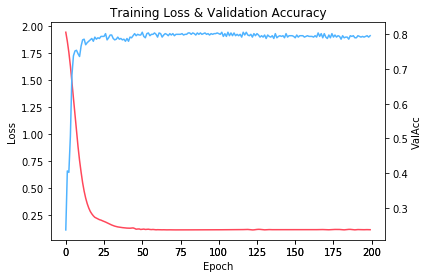

In [12]:
plot_loss_with_acc(loss, val_acc)

In [13]:
test_logits, test_label

(array([[ 0.5106515 ,  0.59341556, -0.19808292, ..., -0.734635  ,
         -0.13036597, -0.29282653],
        [-0.50656515, -0.42324293,  4.490959  , ..., -0.40697753,
         -1.4807918 , -0.8542136 ],
        [-0.48957846,  1.0379071 ,  2.1165938 , ..., -0.86578727,
         -1.3988242 , -1.7559838 ],
        ...,
        [ 2.100123  ,  2.5581636 , -4.1391435 , ..., -3.5364842 ,
          1.1836109 ,  0.6337291 ],
        [-0.91950095, -0.04575482, -0.24669635, ...,  0.71824455,
         -2.111446  , -1.7071737 ],
        [-0.90880615,  0.08546245, -0.09092414, ...,  0.37782782,
         -1.6366246 , -1.7406329 ]], dtype=float32),
 array([3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 4, 4, 4,
        4, 1, 1, 3, 1, 0, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 

上面是完整的定义图网络，处理图数据并进行训练的过程，实际上，有一个图神经网络库帮我们实现了图网络的结构，并且包含了`Cora`数据集，这个库就是`pytorch_geometric(PyG)`,接下来我们使用库来实现上面的过程。

In [18]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Using exist file ind.cora.x


URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))